In [3]:
pip install numpy matplotlib torch torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Round 1/10, Train Loss: 0.8762, Train Accuracy: 0.7914, Test Loss: 1.5124, Test Accuracy: 0.7844
Round 2/10, Train Loss: 0.6941, Train Accuracy: 0.8571, Test Loss: 0.4264, Test Accuracy: 0.8901
Round 3/10, Train Loss: 0.4010, Train Accuracy: 0.8902, Test Loss: 0.3450, Test Accuracy: 0.9040
Round 4/10, Train Loss: 0.3486, Train Accuracy: 0.9009, Test Loss: 0.3131, Test Accuracy: 0.9108
Round 5/10, Train Loss: 0.3210, Train Accuracy: 0.9075, Test Loss: 0.2928, Test Accuracy: 0.9176
Round 6/10, Train Loss: 0.3008, Train Accuracy: 0.9127, Test Loss: 0.2777, Test Accuracy: 0.9215
Round 7/10, Train Loss: 0.2842, Train Accuracy: 0.9179, Test Loss: 0.2633, Test Accuracy: 0.9242
Round 8/10, Train Loss: 0.2700, Train Accuracy: 0.9214, Test Loss: 0.2517, Test Accuracy: 0.9275
Round 9/10, Train Loss: 0.2565, Train Accuracy: 0.9256, Test Loss: 0.2404, Test Accuracy: 0.9306
Round 10/10, Train Loss: 0.2445, Train Accuracy: 0.9292, Test Loss: 0.2312, Test Accuracy: 0.9325


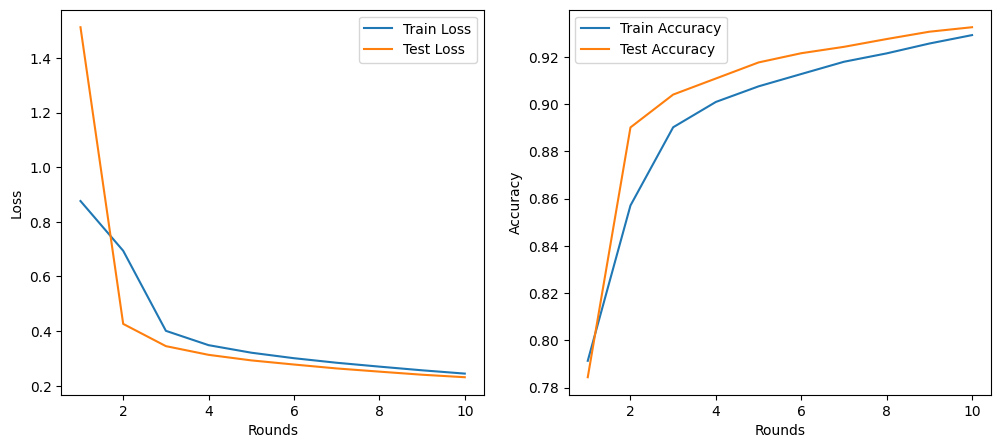

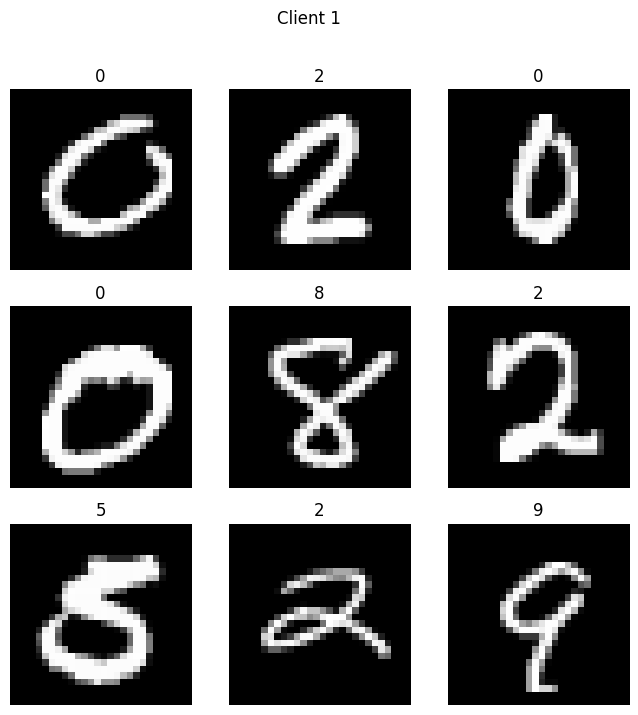

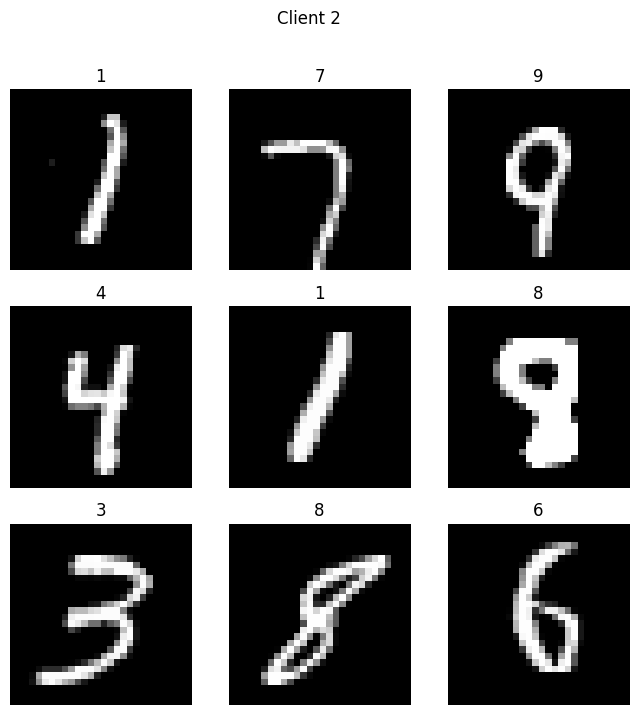

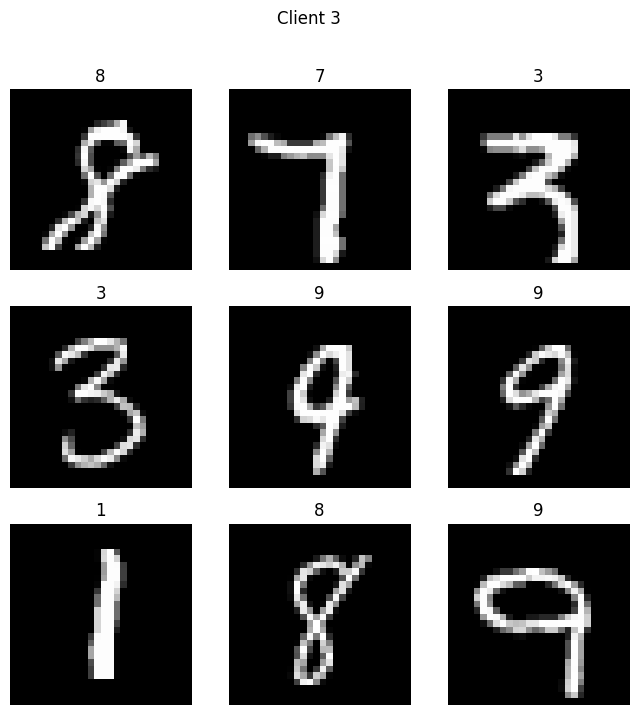

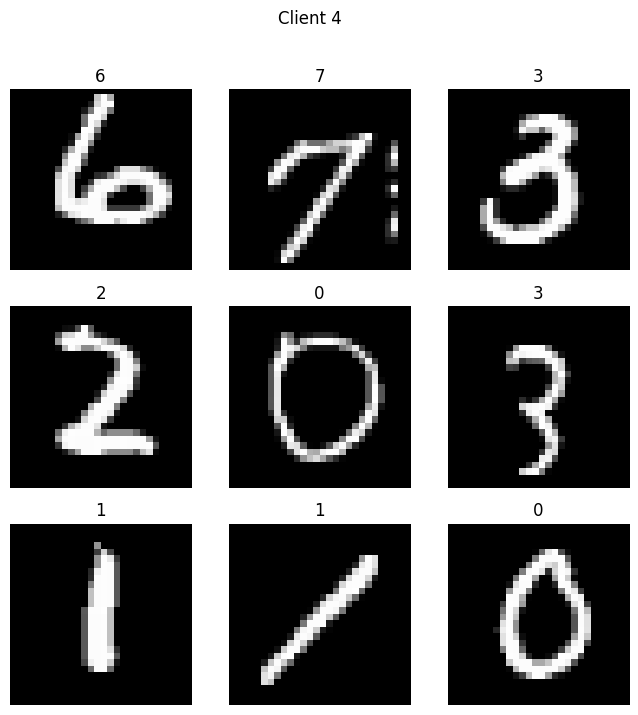

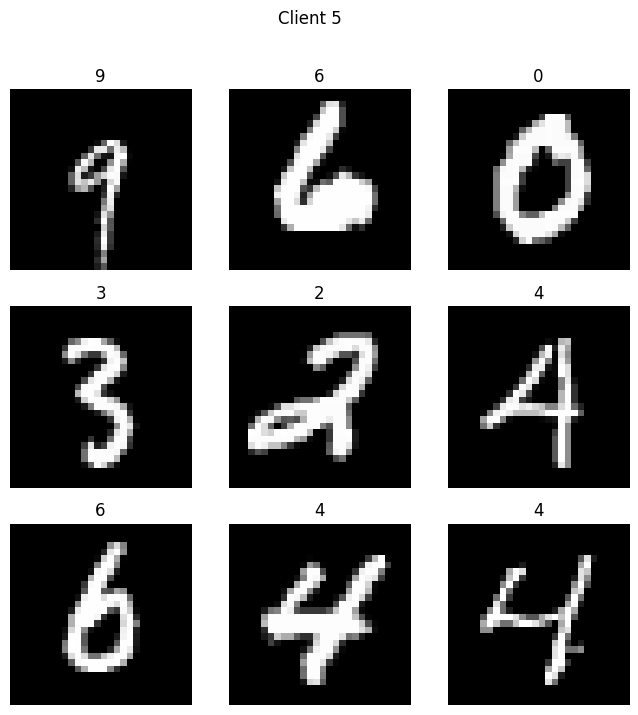

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Hyperparameters
num_clients = 5
num_rounds = 10
epochs_per_round = 1
batch_size = 32
learning_rate = 0.01

# Transformations for MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Load MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split dataset into clients
client_datasets = random_split(mnist_train, [len(mnist_train) // num_clients for _ in range(num_clients)])

# Dataloader function
def get_dataloader(dataset, batch_size=batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create models for each client
client_models = [SimpleNN() for _ in range(num_clients)]
global_model = SimpleNN()

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
client_optimizers = [optim.SGD(model.parameters(), lr=learning_rate) for model in client_models]

# Training function
def train(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for data, target in dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)
    
    return total_loss / total, correct / total

# Testing function
def test(model, dataloader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)
    
    return total_loss / total, correct / total

# Aggregation function
def aggregate_models(global_model, client_models):
    global_dict = global_model.state_dict()
    for key in global_dict.keys():
        global_dict[key] = torch.stack([client_models[i].state_dict()[key] for i in range(num_clients)], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_dict)

# Federated learning simulation
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

test_loader = get_dataloader(mnist_test)

for round in range(num_rounds):
    round_loss, round_accuracy = 0, 0
    for client in range(num_clients):
        client_loader = get_dataloader(client_datasets[client])
        loss, accuracy = train(client_models[client], client_loader, client_optimizers[client])
        round_loss += loss
        round_accuracy += accuracy
    
    # Aggregate client models to global model
    aggregate_models(global_model, client_models)
    
    # Evaluate global model
    loss, accuracy = test(global_model, test_loader)
    train_loss.append(round_loss / num_clients)
    train_accuracy.append(round_accuracy / num_clients)
    test_loss.append(loss)
    test_accuracy.append(accuracy)
    
    print(f"Round {round+1}/{num_rounds}, Train Loss: {round_loss / num_clients:.4f}, Train Accuracy: {round_accuracy / num_clients:.4f}, Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Plotting results
rounds = np.arange(1, num_rounds + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rounds, train_loss, label='Train Loss')
plt.plot(rounds, test_loss, label='Test Loss')
plt.xlabel('Rounds')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_accuracy, label='Train Accuracy')
plt.plot(rounds, test_accuracy, label='Test Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Display sample output images from clients
def show_images(dataset, title):
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, 10):
        img, label = dataset[i]
        figure.add_subplot(3, 3, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.suptitle(title)
    plt.show()

for client in range(num_clients):
    show_images(client_datasets[client], f"Client {client+1}")
